# Diabetes Health Indicators: Random Forest & Baselines

In [1]:
# Load packages needed
import sys
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
from scipy.stats import randint

In [2]:
print('### Python version: ' + sys.version)
print('### Numpy version: ' + np.__version__)
print('### Pandas version: ' + pd.__version__)
print('### Matplotlib version: ' + matplotlib.__version__)
print('### Scikit-learn version: ' + sklearn.__version__)
print('------------')

### Python version: 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:40:35) [GCC 12.3.0]
### Numpy version: 1.26.4
### Pandas version: 2.2.1
### Matplotlib version: 3.8.2
### Scikit-learn version: 1.3.2
------------


In [3]:
# Set the seed for reproducibility
seed = 42

In [4]:
# Import data 
df = pd.read_csv('data/diabetes_012_health_indicators_BRFSS2015.csv')
df.drop_duplicates(inplace=True)

# Check that data imported correctly
df.head(5)

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [5]:
# Put all the data into a numpy matrix
all_xy = df.to_numpy()

# Get feature and target names
feature_names = list(df.columns[1:])
target_names = df.columns[0]

# Show the features and target
print('features: {} --- target: {}'.format(feature_names, target_names))

features: ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income'] --- target: Diabetes_012


In [6]:
# Split the data into features (X) and the target variable (y)
X = df.drop(['Diabetes_012'], axis=1)
y = df['Diabetes_012']

print(X.shape)
print(y.shape)

(229781, 21)
(229781,)


## Feature scaling & train-test-val split

In [7]:
# Scale features using min-max scaler
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

In [8]:
# Split the data into train-validation-test sets: 90-0.05-0.05
train_x, temp_x, train_y, temp_y = train_test_split(scaled_X, y, test_size=0.1, random_state=seed)
val_x, test_x, val_y, test_y = train_test_split(temp_x, temp_y, test_size=0.5, random_state=seed)

In [9]:
target_col = df.columns[0]
df_excluded = df.drop(columns=[target_col])
train_df = pd.DataFrame(train_x, columns=df_excluded.columns)
train_df['Diabetes_012'] = train_y 

# Get unique classes for ROC curve
classes = np.unique(train_y)

## Define Functions

In [10]:
# Function to plot ROC curves
def plot_multiclass_roc_curve(y, prob_pred_y, classes, title):
    plt.figure(figsize=(8, 6))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y == i, prob_pred_y[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {classes[i]} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title(title)
    plt.legend()
    plt.grid(True)
    #plt.savefig('ROC_Curve_UC_SMOTE.jpg', dpi=400)
    plt.show()
    
 

In [11]:
# Function to train and evaluate RF models
def train_and_evaluate_rf(num_estimators, train_x, train_y, test_x, test_y, val_x, val_y):
    # Make the RF classifier
    rf = RandomForestClassifier(n_estimators=num_estimators, random_state=seed)
    
    # Train the model
    rf.fit(train_x, train_y)
    
    # Make predictions
    train_pred = rf.predict(train_x)
    test_pred = rf.predict(test_x)
    val_pred = rf.predict(val_x)
    
    # Evaluate the model
    train_acc = accuracy_score(train_y, train_pred)
    test_acc = accuracy_score(test_y, test_pred)
    val_acc = accuracy_score(val_y, val_pred)
    
    # Predict probabilities for each class
    train_pred_prob_y = rf.predict_proba(train_x)
    test_pred_prob_y = rf.predict_proba(test_x)
    val_pred_prob_y = rf.predict_proba(val_x)
    
    class_report = classification_report(test_y, test_pred)
    
    return train_pred, train_acc, train_pred_prob_y, test_pred, test_acc, test_pred_prob_y, val_pred, val_acc, val_pred_prob_y, class_report
    

## Data Imbalance Techniques & Model Training + Evaluation

### Upsampling

In [12]:
from sklearn.utils import resample
from sklearn.utils import class_weight

# # #1: Upsampling (Over-sampling)
# Separate majority and minority classes
majority_class = train_df[train_df['Diabetes_012'] == 0]
minority_class1 = train_df[train_df['Diabetes_012'] == 1]
minority_class2 = train_df[train_df['Diabetes_012'] == 2]

# Upsample minority class
minority_upsampled1 = resample(minority_class1, 
                               replace=True,     # sample with replacement
                               n_samples=len(majority_class),    # to match majority class
                               random_state=42)

minority_upsampled2 = resample(minority_class2, 
                               replace=True,     # sample with replacement
                               n_samples=len(majority_class),    # to match majority class
                               random_state=42)

# Combine majority class with upsampled minority class
upsampled = pd.concat([majority_class, minority_upsampled1, minority_upsampled2])

# Shuffle the upsampled DataFrame to ensure randomness
upsampled = upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

target_distribution = upsampled['Diabetes_012'].value_counts()
print(target_distribution)

Diabetes_012
0.0    140844
2.0    140844
1.0    140844
Name: count, dtype: int64


In [13]:
# Put upsampled training data into a numpy matrix
upsamp_train_xy = upsampled.to_numpy()

# Split the upsampled training data into features and target
upsamp_train_x = upsamp_train_xy[:, :-1]
upsamp_train_y = upsamp_train_xy[:, -1]

#### Train & Evaluate Upsampled Model

RF Upsampled Train accuracy: 99.92%
RF Upsampled Test accuracy: 80.33%
RF Upsampled Validation accuracy: 80.61%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.97      0.89      9516
         1.0       0.05      0.00      0.01       249
         2.0       0.10      0.02      0.03      1725

    accuracy                           0.80     11490
   macro avg       0.33      0.33      0.31     11490
weighted avg       0.70      0.80      0.74     11490



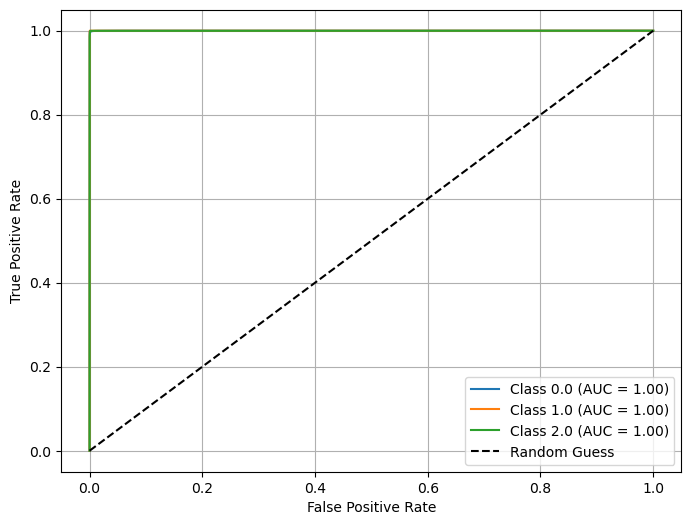

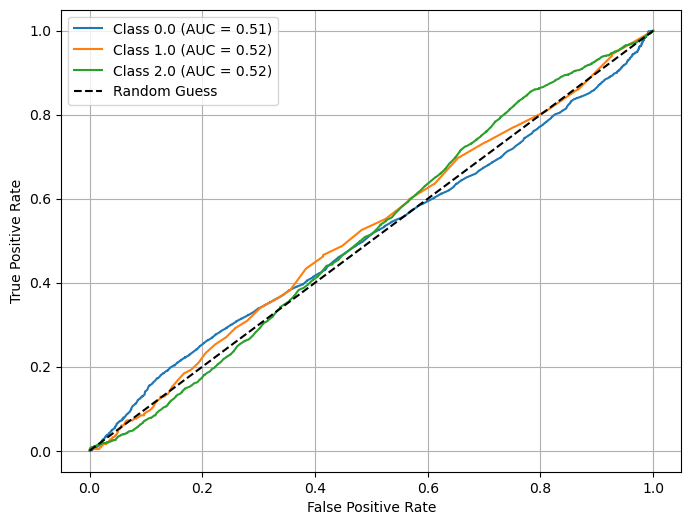

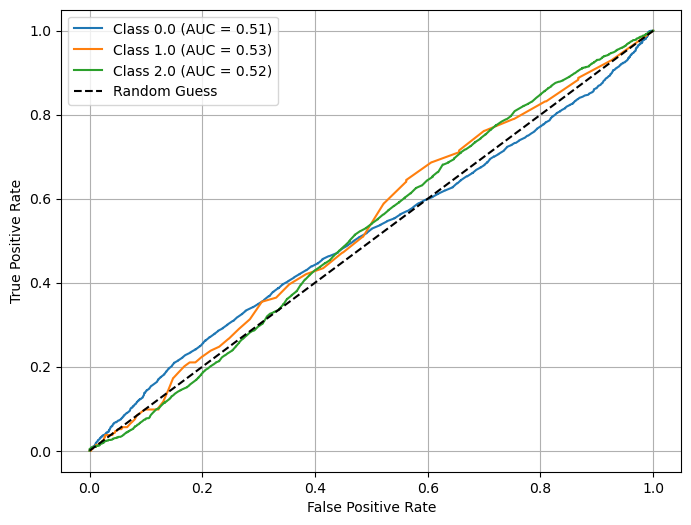

In [14]:
estimators = 500

# Train and evaluate the upsampled data
upsamp_train_pred, upsamp_train_acc, upsamp_train_pred_prob_y, upsamp_test_pred, upsamp_test_acc, upsamp_test_pred_prob_y, upsamp_val_pred, upsamp_val_acc, upsamp_val_pred_prob_y, upsamp_class_report = train_and_evaluate_rf(estimators, upsamp_train_x, upsamp_train_y, test_x, test_y, val_x, val_y)

# Print results
print('RF Upsampled Train accuracy: {:.2f}%'.format(upsamp_train_acc*100))
print('RF Upsampled Test accuracy: {:.2f}%'.format(upsamp_test_acc*100))
print('RF Upsampled Validation accuracy: {:.2f}%'.format(upsamp_val_acc*100))
print('Classification Report:')
print(upsamp_class_report)

# Make ROC curves
plot_multiclass_roc_curve(upsamp_train_y, upsamp_train_pred_prob_y, classes, 'ROC Curve - Upsampled Train Set')
plot_multiclass_roc_curve(test_y, upsamp_test_pred_prob_y, classes, 'ROC Curve - Upsampled Test Set')
plot_multiclass_roc_curve(val_y, upsamp_val_pred_prob_y, classes, 'ROC Curve - Upsampled Validation Set')

### Downsampling

In [15]:
#2: Downsampling (Under-sampling)
majority_class = train_df[train_df['Diabetes_012'] == 0]
minority_class1 = train_df[train_df['Diabetes_012'] == 1]
minority_class2 = train_df[train_df['Diabetes_012'] == 2]

# Downsample majority class
majority_downsampled1 = resample(majority_class, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(minority_class1),
                                 random_state=42)

majority_downsampled2 = resample(minority_class2, 
                                 replace=False,
                                 n_samples=len(minority_class1), 
                                 random_state=42)

# Combine minority class with downsampled majority classes
downsampled = pd.concat([majority_downsampled1, minority_class1, majority_downsampled2])

# Shuffle the downsampled DataFrame to ensure randomness
downsampled = downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

target_distribution = downsampled['Diabetes_012'].value_counts()
print(target_distribution)

Diabetes_012
0.0    3434
2.0    3434
1.0    3434
Name: count, dtype: int64


In [16]:
# Put downsampled training data into a numpy matrix
downsamp_train_xy = downsampled.to_numpy()

# Split the downsampled training data into features and target
downsamp_train_x = downsamp_train_xy[:, :-1]
downsamp_train_y = downsamp_train_xy[:, -1]

#### Train & Evaluate Downsampled Model

RF Downsampled Train accuracy: 99.97%
RF Downsampled Test accuracy: 33.42%
RF Downsampled Validation accuracy: 34.05%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.33      0.48      9516
         1.0       0.02      0.33      0.04       249
         2.0       0.15      0.34      0.21      1725

    accuracy                           0.33     11490
   macro avg       0.33      0.33      0.24     11490
weighted avg       0.71      0.33      0.43     11490



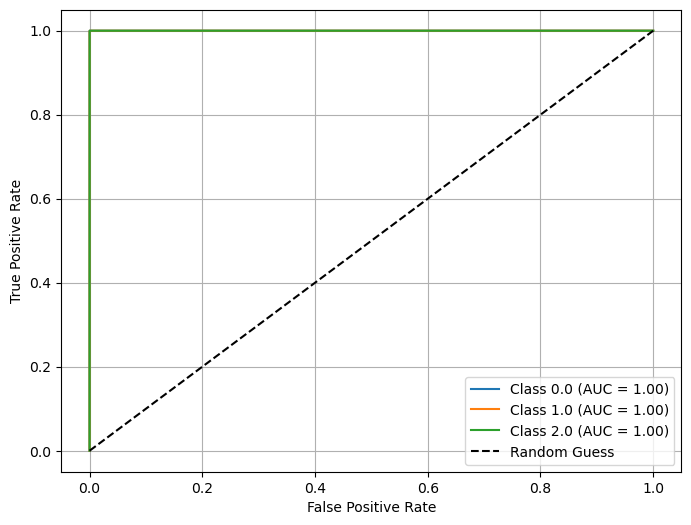

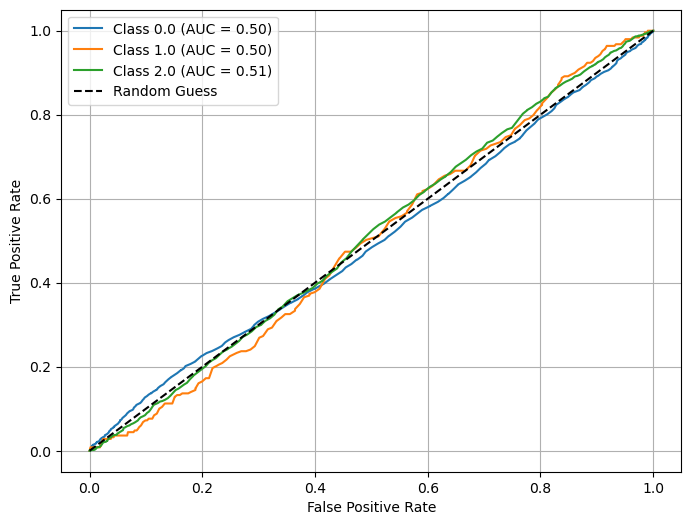

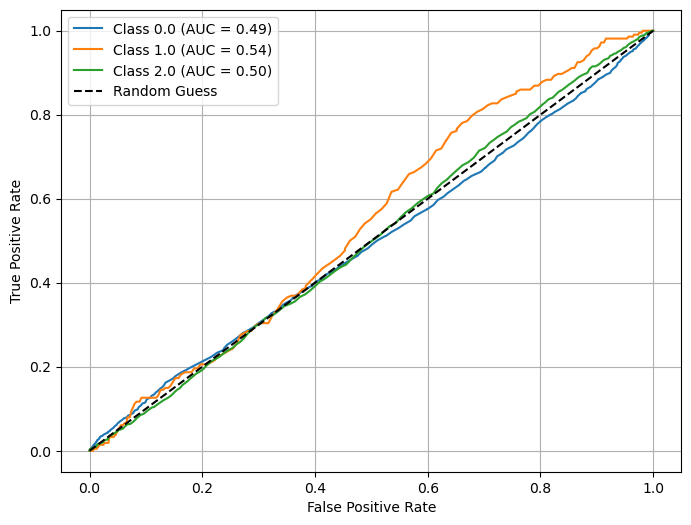

In [17]:
estimators = 500

# Train and evaluate the downsampled data
downsamp_train_pred, downsamp_train_acc, downsamp_train_pred_prob_y, downsamp_test_pred, downsamp_test_acc, downsamp_test_pred_prob_y, downsamp_val_pred, downsamp_val_acc, downsamp_val_pred_prob_y, downsamp_class_report = train_and_evaluate_rf(estimators, downsamp_train_x, downsamp_train_y, test_x, test_y, val_x, val_y)

# Print results
print('RF Downsampled Train accuracy: {:.2f}%'.format(downsamp_train_acc*100))
print('RF Downsampled Test accuracy: {:.2f}%'.format(downsamp_test_acc*100))
print('RF Downsampled Validation accuracy: {:.2f}%'.format(downsamp_val_acc*100))
print('Classification Report:')
print(downsamp_class_report)

# Make ROC curves
plot_multiclass_roc_curve(downsamp_train_y, downsamp_train_pred_prob_y, classes, 'ROC Curve - Downsampled Train Set')
plot_multiclass_roc_curve(test_y, downsamp_test_pred_prob_y, classes, 'ROC Curve - Downsampled Test Set')
plot_multiclass_roc_curve(val_y, downsamp_val_pred_prob_y, classes, 'ROC Curve - Downsampled Validation Set')

### SMOTE

In [18]:
from imblearn.over_sampling import SMOTE

#3: Apply SMOTE: generates synthetic samples for the minority class to balance the class distribution
smote = SMOTE(random_state=42)
smote_train_x, smote_train_y = smote.fit_resample(train_x, train_y)

target_distribution = smote_train_y.value_counts()
print(target_distribution)

Diabetes_012
0.0    171019
2.0    171019
1.0    171019
Name: count, dtype: int64


#### Train & Evaluate SMOTE Model

RF SMOTE Train accuracy: 99.70%
RF SMOTE Test accuracy: 80.76%
RF SMOTE Validation accuracy: 81.30%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.92      0.89      9516
         1.0       0.04      0.01      0.01       249
         2.0       0.40      0.32      0.36      1725

    accuracy                           0.81     11490
   macro avg       0.44      0.41      0.42     11490
weighted avg       0.78      0.81      0.79     11490



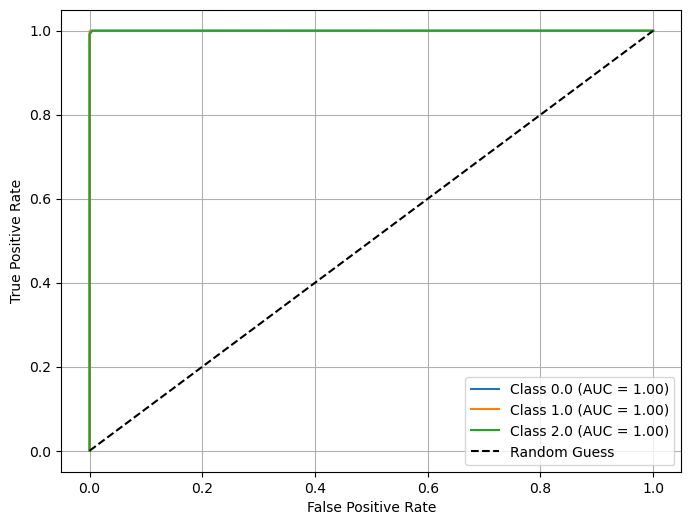

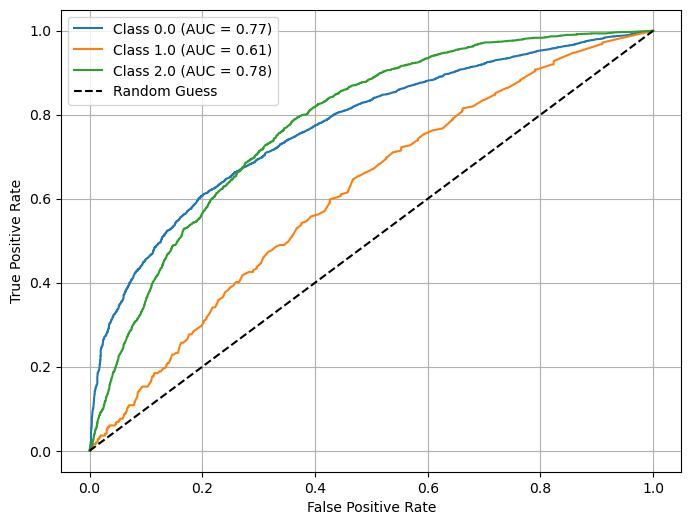

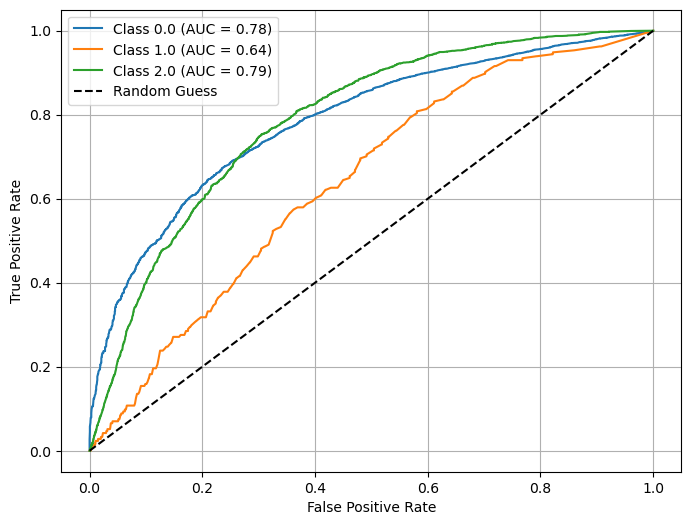

In [19]:
estimators = 1000

# Train and evaluate the SMOTE data
smote_train_pred, smote_train_acc, smote_train_pred_prob_y, smote_test_pred, smote_test_acc, smote_test_pred_prob_y, smote_val_pred, smote_val_acc, smote_val_pred_prob_y, smote_class_report = train_and_evaluate_rf(estimators, smote_train_x, smote_train_y, test_x, test_y, val_x, val_y)

# Print results
print('RF SMOTE Train accuracy: {:.2f}%'.format(smote_train_acc*100))
print('RF SMOTE Test accuracy: {:.2f}%'.format(smote_test_acc*100))
print('RF SMOTE Validation accuracy: {:.2f}%'.format(smote_val_acc*100))
print('Classification Report:')
print(smote_class_report)

# Make ROC curves
plot_multiclass_roc_curve(smote_train_y, smote_train_pred_prob_y, classes, 'ROC Curve - SMOTE Train Set')
plot_multiclass_roc_curve(test_y, smote_test_pred_prob_y, classes, 'ROC Curve - SMOTE Test Set')
plot_multiclass_roc_curve(val_y, smote_val_pred_prob_y, classes, 'ROC Curve - SMOTE Validation Set')

# Dummy Classifier

### Upsampled

DC Train accuracy: 33.23%
DC Test accuracy: 33.94%
DC Validation accuracy: 33.08%


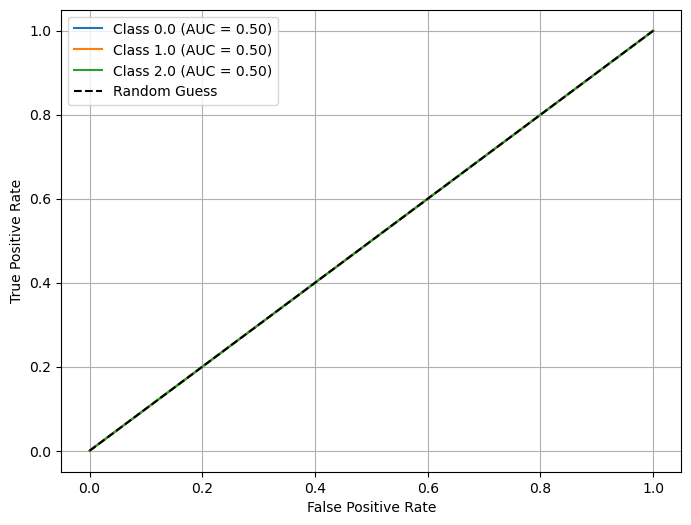

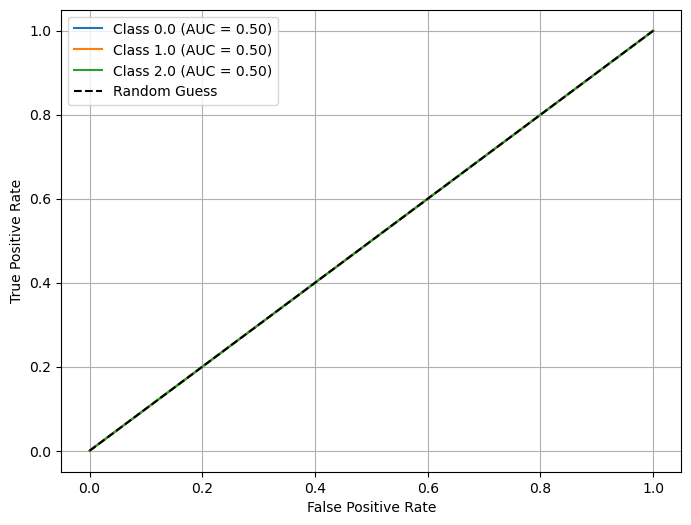

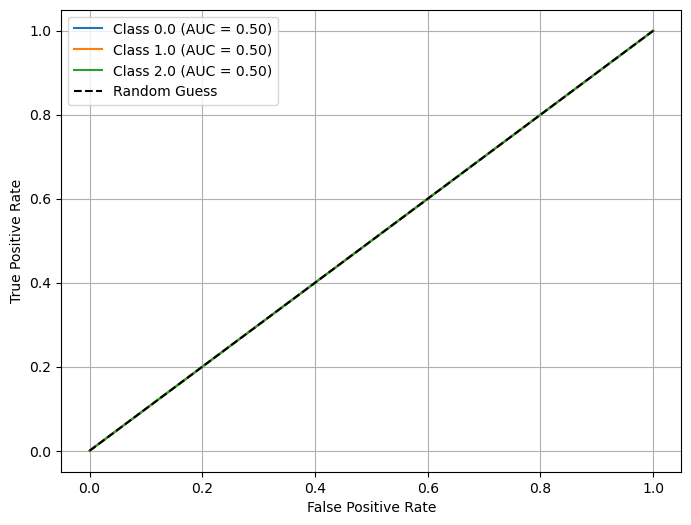

In [20]:
dc = DummyClassifier(strategy='uniform', random_state=seed)
dc.fit(upsamp_train_x, upsamp_train_y)

# Make predictions
dc_upsamp_train_pred = dc.predict(upsamp_train_x)
dc_upsamp_test_pred = dc.predict(test_x)
dc_upsamp_val_pred = dc.predict(val_x)

# Evaluate the model
dc_upsamp_train_acc = accuracy_score(upsamp_train_y, dc_upsamp_train_pred)
dc_upsamp_test_acc = accuracy_score(test_y, dc_upsamp_test_pred)
dc_upsamp_val_acc = accuracy_score(val_y, dc_upsamp_val_pred)

print('DC Train accuracy: {:.2f}%'.format(dc_upsamp_train_acc*100))
print('DC Test accuracy: {:.2f}%'.format(dc_upsamp_test_acc*100))
print('DC Validation accuracy: {:.2f}%'.format(dc_upsamp_val_acc*100))

dc_upsamp_train_pred_prob_y = dc.predict_proba(upsamp_train_x)
dc_upsamp_test_pred_prob_y = dc.predict_proba(test_x)
dc_upsamp_val_pred_prob_y = dc.predict_proba(val_x)

plot_multiclass_roc_curve(upsamp_train_y, dc_upsamp_train_pred_prob_y, classes, 'ROC Curve - DC Upsampled Train Set')
plot_multiclass_roc_curve(test_y, dc_upsamp_test_pred_prob_y, classes, 'ROC Curve - DC Upsampled Test Set')
plot_multiclass_roc_curve(val_y, dc_upsamp_val_pred_prob_y, classes, 'ROC Curve - DC Upsampled Validation Set')

### Downsampled

DC Train accuracy: 33.52%
DC Test accuracy: 33.94%
DC Validation accuracy: 33.08%


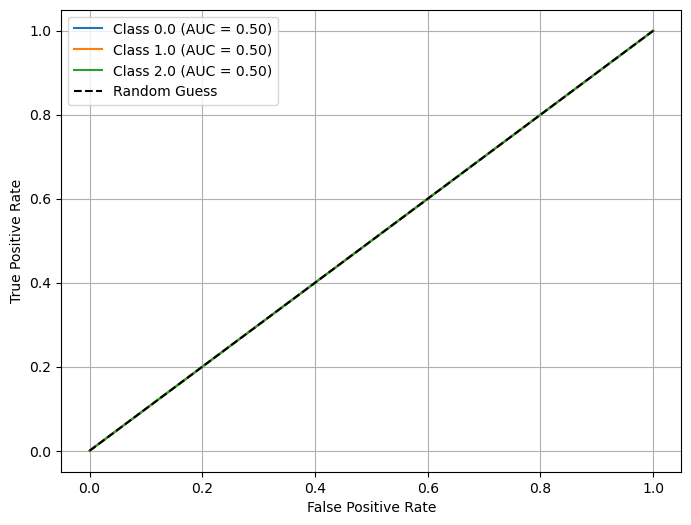

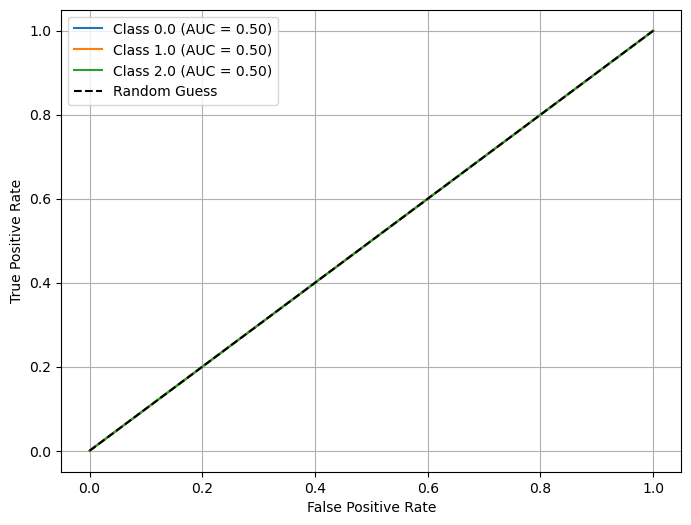

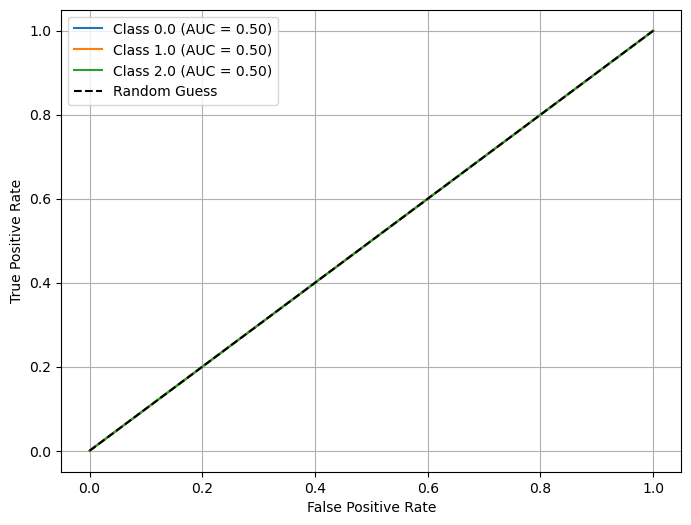

In [21]:
dc.fit(downsamp_train_x, downsamp_train_y)

# Make predictions
dc_downsamp_train_pred = dc.predict(downsamp_train_x)
dc_downsamp_test_pred = dc.predict(test_x)
dc_downsamp_val_pred = dc.predict(val_x)

# Evaluate the model
dc_downsamp_train_acc = accuracy_score(downsamp_train_y, dc_downsamp_train_pred)
dc_downsamp_test_acc = accuracy_score(test_y, dc_downsamp_test_pred)
dc_downsamp_val_acc = accuracy_score(val_y, dc_downsamp_val_pred)

print('DC Train accuracy: {:.2f}%'.format(dc_downsamp_train_acc*100))
print('DC Test accuracy: {:.2f}%'.format(dc_downsamp_test_acc*100))
print('DC Validation accuracy: {:.2f}%'.format(dc_downsamp_val_acc*100))

dc_downsamp_train_pred_prob_y = dc.predict_proba(downsamp_train_x)
dc_downsamp_test_pred_prob_y = dc.predict_proba(test_x)
dc_downsamp_val_pred_prob_y = dc.predict_proba(val_x)

plot_multiclass_roc_curve(downsamp_train_y, dc_downsamp_train_pred_prob_y, classes, 'ROC Curve - DC Downsampled Train Set')
plot_multiclass_roc_curve(test_y, dc_downsamp_test_pred_prob_y, classes, 'ROC Curve - DC Downsampled Test Set')
plot_multiclass_roc_curve(val_y, dc_downsamp_val_pred_prob_y, classes, 'ROC Curve - DC Downsampled Validation Set')

### SMOTE

DC Train accuracy: 33.38%
DC Test accuracy: 33.94%
DC Validation accuracy: 33.08%


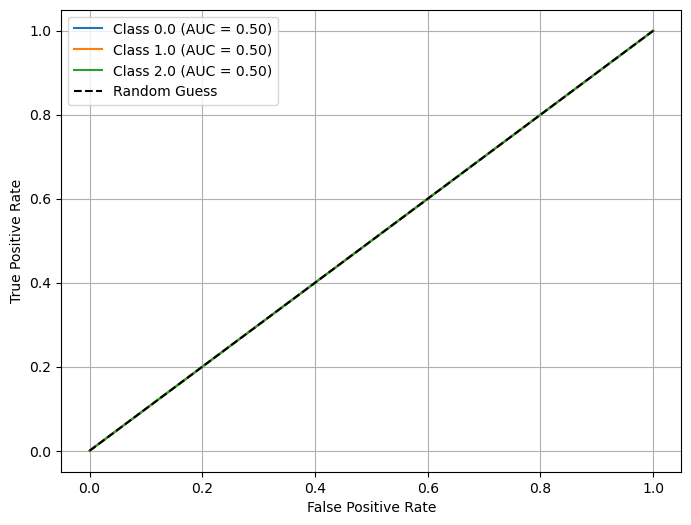

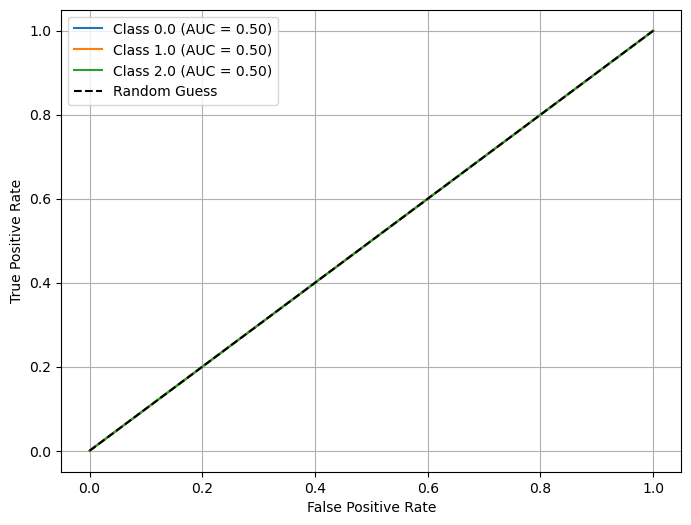

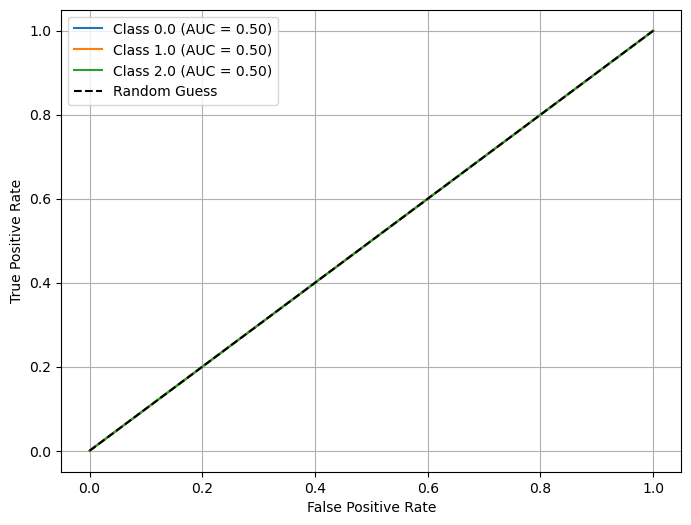

In [22]:
dc.fit(smote_train_x, smote_train_y)

# Make predictions
dc_smote_train_pred = dc.predict(smote_train_x)
dc_smote_test_pred = dc.predict(test_x)
dc_smote_val_pred = dc.predict(val_x)

# Evaluate the model
dc_smote_train_acc = accuracy_score(smote_train_y, dc_smote_train_pred)
dc_smote_test_acc = accuracy_score(test_y, dc_smote_test_pred)
dc_smote_val_acc = accuracy_score(val_y, dc_smote_val_pred)

print('DC Train accuracy: {:.2f}%'.format(dc_smote_train_acc*100))
print('DC Test accuracy: {:.2f}%'.format(dc_smote_test_acc*100))
print('DC Validation accuracy: {:.2f}%'.format(dc_smote_val_acc*100))

dc_smote_train_pred_prob_y = dc.predict_proba(smote_train_x)
dc_smote_test_pred_prob_y = dc.predict_proba(test_x)
dc_smote_val_pred_prob_y = dc.predict_proba(val_x)

plot_multiclass_roc_curve(smote_train_y, dc_smote_train_pred_prob_y, classes, 'ROC Curve - DC SMOTE Train Set')
plot_multiclass_roc_curve(test_y, dc_smote_test_pred_prob_y, classes, 'ROC Curve - DC SMOTE Test Set')
plot_multiclass_roc_curve(val_y, dc_smote_val_pred_prob_y, classes, 'ROC Curve - DC SMOTE Validation Set')